In [1]:
import psycopg2
import dotenv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle, Arc, ConnectionPatch
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
from scipy.ndimage import gaussian_filter


In [2]:
dotenv.load_dotenv()

PG_PASSWORD = os.getenv("PG_PASSWORD")
PG_USER = os.getenv("PG_USER")
PG_HOST = os.getenv("PG_HOST")
PG_PORT = os.getenv("PG_PORT")
PG_DATABASE = os.getenv("PG_DB")

# Event mappings
event_type_mapping = {
    0: 'pass',
    1: 'cross',
    2: 'throw in',
    3: 'freekick crossed',
    4: 'freekick short',
    5: 'corner crossed',
    6: 'corner short',
    7: 'take on',
    8: 'foul',
    9: 'tackle',
    10: 'interception',
    11: 'shot',
    12: 'shot penalty',
    13: 'shot freekick',
    14: 'keeper save',
    18: 'clearance',
    21: 'dribble',
    22: 'goalkick'
}

result_mapping = {
    0: 'fail',
    1: 'success'
}

In [3]:
def get_connection():
    return psycopg2.connect(
        host=PG_HOST,
        database=PG_DATABASE,
        user=PG_USER,
        password=PG_PASSWORD,
        port=PG_PORT,
        sslmode="require",
    )

def get_event_data(game_id):
    query = """
    SELECT 
    e.name AS event_type_name,
    me.eventtype_id AS event_type_uuid,
    me.player_id, 
    me.team_id, 
    me.x AS start_x, 
    me.y AS start_y,
    me.end_coordinates_x,
    me.end_coordinates_y,
    me.match_id AS game_id, 
    me.timestamp AS time,
    me.end_timestamp,
    me.result AS outcome_text,
    me.period_id
    FROM matchevents me
    JOIN eventtypes e ON me.eventtype_id = e.eventtype_id
    WHERE me.match_id = '5pcyhm34h5c948yji4oryevpw'
    """
    connection = get_connection()
    df = pd.read_sql(query, connection, params=(game_id,))
    connection.close()
    
    if df.empty:
        print("No data returned from query")
        return df
    
    print(f"Data fetched: {len(df)} rows")
    
    # Clean and convert timestamps
    try:
        df["time"] = df["time"].astype(str).str.extract(r'(\d+\.\d+)')[0].astype(float)
        df["end_timestamp"] = df["end_timestamp"].astype(str).str.extract(r'(\d+\.\d+)')[0].astype(float)
        df["seconds"] = df["time"]
    except Exception as e:
        print(f"Error processing timestamps: {e}")
    
    # Create an event type mapping based on the event_type_name
    # Map database event names to your numeric action_type values
    event_name_to_id = {
        'Pass': 0,
        'Cross': 1,
        'Throw In': 2,
        'Free Kick': 3,  # You might need to differentiate between crossed/short
        'Corner': 5,     # You might need to differentiate between crossed/short
        'Take On': 7,
        'Foul': 8,
        'Tackle': 9,
        'Interception': 10,
        'Shot': 11,
        'Penalty': 12,
        'Save': 14,
        'Clearance': 18,
        'Dribble': 21,
        'Goal Kick': 22
    }
    
    # Create a mapping for outcome text to numeric outcome (success/fail)
    outcome_text_to_id = {
        'COMPLETE': 1,
        'INCOMPLETE': 0,
        'LOST': 0,
        'WON': 1,
        'SUCCESS': 1,
        'OFF_TARGET': 0,
        'OUT': 0,
        'BLOCKED': 0,
        'GOAL': 1,
        'SAVED': 0
    }
    
    # Create new columns with mapped numeric values
    # Map event type names to numeric IDs, defaulting to -1 if not found
    df['action_type'] = df['event_type_name'].apply(
        lambda x: next((id for name, id in event_name_to_id.items() 
                      if name.upper() in str(x).upper()), -1))
    
    # Map outcome text to numeric outcome, defaulting to 0 (fail) if not found
    df['outcome'] = df['outcome_text'].map(outcome_text_to_id).fillna(0).astype(int)
    
    # Create result_name from outcome
    df['result_name'] = df['outcome'].map(result_mapping)
    
    # Drop rows with missing coordinates
    initial_count = len(df)
    df = df.dropna(subset=['start_x', 'start_y'])
    dropped_count = initial_count - len(df)
    if dropped_count > 0:
        print(f"Dropped {dropped_count} rows with missing coordinates")
    
    # Print debug information 
    print("\nEvent type mapping results:")
    print(df['action_type'].value_counts().head(10))
    print("\nOutcome mapping results:")
    print(df['outcome'].value_counts())
    
    return df

In [ ]:
def calculate_xt(df, grid_size=16):
    """Calculate xT values with improved weight handling."""
    pitch_length = 105
    pitch_width = 68
    
    xt_grid = np.zeros((grid_size, grid_size))
    pass_grid = np.zeros((grid_size, grid_size))
    shot_grid = np.zeros((grid_size, grid_size))
    
    def coord_to_index(x, y):
        x_idx = min(int((x / pitch_length) * grid_size), grid_size - 1)
        y_idx = min(int((y / pitch_width) * grid_size), grid_size - 1)
        return x_idx, y_idx

    # Define weights directly as numeric values, not strings
    # This is the critical change - using fixed values with proper scaling
    action_weights = {
        0: {'success': 0.2, 'fail': 0.0},    # Pass
        1: {'success': 0.3, 'fail': 0.1},    # Cross
        2: {'success': 0.1, 'fail': 0.0},    # Throw-in
        3: {'success': 0.2, 'fail': 0.1},    # Free kick 
        5: {'success': 0.3, 'fail': 0.1},    # Corner
        7: {'success': 0.2, 'fail': 0.1},    # Take-on
        8: {'success': 0.0, 'fail': 0.0},    # Foul (no xT)
        9: {'success': 0.1, 'fail': 0.0},    # Tackle
        10: {'success': 0.1, 'fail': 0.0},   # Interception
        11: {'success': 0.6, 'fail': 0.2},   # Shot
        12: {'success': 0.8, 'fail': 0.3},   # Penalty
        14: {'success': 0.0, 'fail': 0.0},   # Save
        18: {'success': 0.1, 'fail': 0.0},   # Clearance
        21: {'success': 0.2, 'fail': 0.1},   # Dribble
        22: {'success': 0.1, 'fail': 0.0}    # Goal kick
    }
    
    # Add a default weight for unmapped actions
    default_weight = {'success': 0.1, 'fail': 0.0}
    
    # Process each event
    valid_events = 0
    weight_count = 0
    missing_weights = 0
    
    for _, row in df.iterrows():
        try:
            # Extract coordinates
            x1, y1 = float(row['start_x']), float(row['start_y'])
            
            # Skip if out of bounds
            if x1 < 0 or x1 > pitch_length or y1 < 0 or y1 > pitch_width:
                continue
                
            # Convert to grid indices
            x1_idx, y1_idx = coord_to_index(x1, y1)
            
            # Get action type and outcome
            action_type = int(row['action_type'])
            outcome = 'success' if row['outcome'] == 1 else 'fail'
            
            # Get weight using action_type
            weight_dict = action_weights.get(action_type, default_weight)
            weight = weight_dict.get(outcome, 0)
            
            if weight == 0:
                missing_weights += 1
                
            # Apply weight to grids
            xt_grid[x1_idx, y1_idx] += weight
            weight_count += weight
            
            # Update specific grids
            if action_type == 0:  # Pass
                pass_grid[x1_idx, y1_idx] += weight
            elif action_type == 11:  # Shot
                shot_grid[x1_idx, y1_idx] += weight
            
            valid_events += 1
                
        except (ValueError, TypeError, IndexError) as e:
            continue
    
    print(f"Valid events processed: {valid_events}")
    print(f"Total weight added: {weight_count:.2f}")
    print(f"Grid before processing - Min: {xt_grid.min():.4f}, Max: {xt_grid.max():.4f}")
    
    # Process grids
    def process_grid(grid):
        if np.all(grid == 0):
            print("Empty grid detected")
            return np.ones((grid_size, grid_size)) * 0.01
            
        # Apply Gaussian filter
        grid = gaussian_filter(grid, sigma=0.8)
        
        # Normalize to [0,1]
        if grid.max() > 0:
            grid = (grid - grid.min()) / (grid.max() - grid.min())
        
        return grid
    
    # Process all grids
    xt_grid = process_grid(xt_grid)
    pass_grid = process_grid(pass_grid)
    shot_grid = process_grid(shot_grid)
    
    print(f"Grid after processing - Min: {xt_grid.min():.4f}, Max: {xt_grid.max():.4f}")
    
    return {
        'total': xt_grid.T,
        'pass': pass_grid.T,
        'shot': shot_grid.T
    }

In [5]:
def draw_pitch(ax):
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    ax.axis('off')
    ax.add_patch(Rectangle((0, 0), 100, 100, edgecolor='black', facecolor='none', lw=1))
    ax.add_patch(Rectangle((0, 21.1), 16.7, 57.8, edgecolor='black', facecolor='none', lw=1))
    ax.add_patch(Rectangle((83.3, 21.1), 16.7, 57.8, edgecolor='black', facecolor='none', lw=1))
    ax.plot([50, 50], [0, 100], color='black', lw=1)
    ax.add_patch(Arc((50, 50), 20, 20, theta1=0, theta2=360, color='black', lw=1))
    return ax

def plot_xt_heatmap(xt_grid, title="Expected Threat (xT) Heatmap"):
    fig, ax = plt.subplots(figsize=(12, 8))
    draw_pitch(ax)
    
    # Use a different colormap that shows more variation
    cmap = plt.cm.viridis
    
    # Add a small amount of noise to the grid to ensure visual variation
    noise = np.random.normal(0, 0.001, xt_grid.shape)
    vis_grid = xt_grid + noise
    
    img = ax.imshow(vis_grid, cmap=cmap, interpolation='gaussian', 
                   extent=[0, 100, 0, 100], origin='lower', 
                   alpha=0.7)
    
    plt.colorbar(img, ax=ax, label='Normalized xT Value')
    plt.title(title, pad=20)
    plt.tight_layout()
    return fig, ax

In [6]:
def plot_directional_xt(df):
    fig, ax = plt.subplots(figsize=(12, 8))
    draw_pitch(ax)
    
    x_factor = 100 / 105
    y_factor = 100 / 68
    
    # Add debugging counters
    pass_count = 0
    shot_count = 0
    missing_end_coords = 0
    drawn_passes = 0
    drawn_shots = 0
    
    # Print column check and data sample
    print(f"\nColumns available: {df.columns}")
    print(f"Sample end coordinates: {df[['end_coordinates_x', 'end_coordinates_y']].head()}")
    print(f"Action types in data: {df['action_type'].unique()}")
    print(f"Outcome values in data: {df['outcome'].unique()}")
    
    # Check if we have passes and shots
    successful_passes = df[(df['action_type'] == 0) & (df['outcome'] == 1)]
    pass_count = len(successful_passes)
    print(f"Found {pass_count} successful passes")
    
    # Directly access columns instead of using .get()
    for _, row in successful_passes.iterrows():
        try:
            if pd.isna(row['end_coordinates_x']) or pd.isna(row['end_coordinates_y']):
                missing_end_coords += 1
                continue
                
            start_x = float(row['start_x']) * x_factor
            start_y = float(row['start_y']) * y_factor
            end_x = float(row['end_coordinates_x']) * x_factor
            end_y = float(row['end_coordinates_y']) * y_factor
            
            # Add bounds check
            if (0 <= start_x <= 100 and 0 <= start_y <= 100 and 
                0 <= end_x <= 100 and 0 <= end_y <= 100):
                
                # Draw the arrow
                ax.annotate("", xy=(end_x, end_y), xytext=(start_x, start_y),
                           arrowprops=dict(arrowstyle="->", color='green', alpha=0.5, lw=1))
                drawn_passes += 1
        except Exception as e:
            print(f"Error drawing pass: {e}")
            print(f"Row data: {row[['start_x', 'start_y', 'end_coordinates_x', 'end_coordinates_y']]}")

    # Process shots
    shots = df[df['action_type'] == 11]
    shot_count = len(shots)
    print(f"Found {shot_count} shots")
    
    for _, row in shots.iterrows():
        try:
            if pd.isna(row['end_coordinates_x']) or pd.isna(row['end_coordinates_y']):
                missing_end_coords += 1
                continue
                
            start_x = float(row['start_x']) * x_factor
            start_y = float(row['start_y']) * y_factor
            end_x = float(row['end_coordinates_x']) * x_factor
            end_y = float(row['end_coordinates_y']) * y_factor
            
            # Add bounds check
            if (0 <= start_x <= 100 and 0 <= start_y <= 100 and 
                0 <= end_x <= 100 and 0 <= end_y <= 100):
                
                ax.plot(start_x, start_y, 'ro', markersize=8, alpha=0.7)
                ax.annotate("", xy=(end_x, end_y), xytext=(start_x, start_y),
                           arrowprops=dict(arrowstyle="->", color='red', alpha=0.7, lw=2))
                drawn_shots += 1
        except Exception as e:
            print(f"Error drawing shot: {e}")
    
    # If no arrows were drawn, add a text annotation
    if drawn_passes == 0 and drawn_shots == 0:
        ax.text(50, 50, "No valid directional data available", 
                ha='center', va='center', fontsize=14, color='red')
    
    # Final stats
    print(f"Missing end coordinates: {missing_end_coords}")
    print(f"Drew {drawn_passes} pass arrows and {drawn_shots} shot arrows")
    
    plt.title(f"Directional Flow: {drawn_passes} passes, {drawn_shots} shots", pad=20)
    plt.tight_layout()
    
    return fig, ax

In [ ]:
def plot_xt_timeline(df, xt_grids):
    """Create xT timeline with event-based approach rather than grid-based."""
    if 'seconds' not in df.columns:
        print("Missing 'seconds' column for timeline plot")
        return None, None
        
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Sort events by time
    sorted_events = df.sort_values('seconds').copy()
    
    # Create a direct event-based xT calculation instead of looking up grid values
    # This gives us more direct and accurate xT values per event
    
    # Define weights as in calculate_xt
    action_weights = {
        0: {'success': 0.2, 'fail': 0.0},    # Pass
        1: {'success': 0.3, 'fail': 0.1},    # Cross
        2: {'success': 0.1, 'fail': 0.0},    # Throw-in
        3: {'success': 0.2, 'fail': 0.1},    # Free kick 
        5: {'success': 0.3, 'fail': 0.1},    # Corner
        7: {'success': 0.2, 'fail': 0.1},    # Take-on
        8: {'success': 0.0, 'fail': 0.0},    # Foul (no xT)
        9: {'success': 0.1, 'fail': 0.0},    # Tackle
        10: {'success': 0.1, 'fail': 0.0},   # Interception
        11: {'success': 0.6, 'fail': 0.2},   # Shot
        12: {'success': 0.8, 'fail': 0.3},   # Penalty
        14: {'success': 0.0, 'fail': 0.0},   # Save
        18: {'success': 0.1, 'fail': 0.0},   # Clearance
        21: {'success': 0.2, 'fail': 0.1},   # Dribble
        22: {'success': 0.1, 'fail': 0.0}    # Goal kick
    }
    
    # Calculate xT for each event directly
    sorted_events['event_xt'] = sorted_events.apply(
        lambda row: action_weights.get(
            row['action_type'], {'success': 0.1, 'fail': 0.0}
        ).get('success' if row['outcome'] == 1 else 'fail', 0),
        axis=1
    )
    
    # Calculate cumulative xT
    sorted_events['cumulative_xt'] = sorted_events['event_xt'].cumsum()
    
    # Convert time to minutes
    if 'period_id' in sorted_events.columns:
        sorted_events['game_time'] = sorted_events.apply(
            lambda row: row['seconds']/60 + (row['period_id']-1)*45 
            if not pd.isna(row['period_id']) else row['seconds']/60, 
            axis=1
        )
    else:
        sorted_events['game_time'] = sorted_events['seconds'] / 60
    
    # Print stats for debugging
    print(f"Total events: {len(sorted_events)}")
    print(f"Time range: {sorted_events['game_time'].min():.1f} to {sorted_events['game_time'].max():.1f} minutes")
    print(f"Total xT: {sorted_events['event_xt'].sum():.2f}")
    
    # Plot main timeline
    ax.plot(sorted_events['game_time'], sorted_events['cumulative_xt'], 
            'b-', lw=1, alpha=0.5)
    
    # Add smoothed version
    window = max(5, min(25, len(sorted_events) // 20))
    if len(sorted_events) > window:
        sorted_events['smoothed_xt'] = sorted_events['cumulative_xt'].rolling(
            window=window, center=True, min_periods=1).mean()
        ax.plot(sorted_events['game_time'], sorted_events['smoothed_xt'], 
                'b-', lw=2.5)
    
    # Add fill between
    ax.fill_between(sorted_events['game_time'], 0, 
                    sorted_events['cumulative_xt'], alpha=0.2)
    
    # Add period markers
    if 'period_id' in sorted_events.columns:
        for period in range(2, int(sorted_events['period_id'].max()) + 1):
            ax.axvline(x=(period-1)*45, color='gray', linestyle='--', alpha=0.7)
    
    # Add team-specific lines if available
    if 'team_id' in sorted_events.columns:
        teams = sorted_events['team_id'].unique()
        if len(teams) == 2:
            for i, team_id in enumerate(teams):
                team_data = sorted_events[sorted_events['team_id'] == team_id].sort_values('game_time')
                
                if not team_data.empty:
                    color = 'r-' if i == 0 else 'g-'
                    team_data['team_xt'] = team_data['event_xt'].cumsum()
                    ax.plot(team_data['game_time'], team_data['team_xt'], 
                           color, lw=1, alpha=0.6, label=f"Team {str(team_id)[:4]}")
            
            ax.legend(loc='upper left')
    
    # Set labels and style
    ax.set_xlabel("Game Time (minutes)", fontsize=12)
    ax.set_ylabel("Cumulative xT", fontsize=12)
    ax.set_title("Expected Threat (xT) Timeline", pad=20, fontsize=14)
    ax.grid(True, alpha=0.3)
    
    # Set reasonable limits
    ax.set_xlim(0, sorted_events['game_time'].max() + 5 if not sorted_events.empty else 90)
    
    plt.tight_layout()
    return fig, ax

def plot_player_xt_contributions(df, xt_grid):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    player_contributions = {}
    player_events = {}
    
    for player_id in df['player_id'].unique():
        player_actions = df[df['player_id'] == player_id]
        xt = 0
        event_count = 0
        
        for _, row in player_actions.iterrows():
            if pd.isna(row['start_x']) or pd.isna(row['start_y']):
                continue
                
            x_idx = min(int((row['start_x'] / 105) * 16), 15)
            y_idx = min(int((row['start_y'] / 68) * 16), 15)
            xt += xt_grid[x_idx, y_idx]
            event_count += 1
        
        # Only include players with at least 5 events
        if event_count >= 5:
            player_contributions[player_id] = xt
            player_events[player_id] = event_count
    
    if not player_contributions:
        ax.text(0.5, 0.5, "No player data available", 
                ha='center', va='center', transform=ax.transAxes, fontsize=14)
        return fig, ax
    
    # Get top players by contribution
    top_players = sorted(player_contributions.items(), key=lambda x: x[1], reverse=True)[:10]
    
    # Create more descriptive labels
    players = []
    for pid, _ in top_players:
        # Use formatted player ID and show event count
        player_label = f"Player {str(pid)[:6]} ({player_events[pid]} events)"
        players.append(player_label)
    
    values = [val for _, val in top_players]
    
    # Create horizontal bar chart with improved colors
    bars = sns.barplot(x=values, y=players, palette="viridis", ax=ax)
    
    # Add value annotations
    for i, v in enumerate(values):
        ax.text(v + 0.1, i, f"{v:.2f}", va='center')
    
    # Normalize contribution by event count (efficiency)
    if len(top_players) > 0:
        ax2 = ax.twiny()  # Create second x-axis
        efficiency = [player_contributions[pid]/player_events[pid] for pid, _ in top_players]
        max_eff = max(efficiency)
        norm_eff = [e/max_eff for e in efficiency]
        
        # Add efficiency markers
        for i, eff in enumerate(norm_eff):
            ax2.scatter(eff, i, color='red', s=50, alpha=0.7, zorder=10)
        
        ax2.set_xlim(0, 1.1)
        ax2.set_xlabel("Relative Efficiency (xT per event)", color='red')
        ax2.tick_params(axis='x', colors='red')
    
    ax.set_xlabel("Total xT Contribution")
    ax.set_title("Top Player xT Contributions", pad=20, fontweight='bold')
    plt.tight_layout()
    return fig, ax

Data fetched: 1589 rows

Event type mapping results:
action_type
 0     920
-1     530
 8      60
 18     36
 10     33
 11     10
Name: count, dtype: int64

Outcome mapping results:
outcome
1    822
0    767
Name: count, dtype: int64
Successfully loaded 1589 events for analysis


C:\Users\edrik\AppData\Local\Temp\ipykernel_27616\3693040242.py:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection, params=(game_id,))


,event_type_name,event_type_uuid,player_id,team_id,start_x,start_y,end_coordinates_x,end_coordinates_y,game_id,time,end_timestamp,outcome_text,period_id,seconds,action_type,outcome,result_name
0,PASS,e319ac55-ffaf-4e6d-87f7-7601d91bcd33,6g9x1y7xmjzwhk646v1iyuup5,cyrrlv6l1onld5x247w1q1jlr,50.0,50.0,37.0,49.3,5pcyhm34h5c948yji4oryevpw,0.087,1.627,COMPLETE,1,0.087,0,1,success
1,PASS,e319ac55-ffaf-4e6d-87f7-7601d91bcd33,cfxzvlgvt9jj17qxq41t9sxcl,cyrrlv6l1onld5x247w1q1jlr,39.1,48.0,32.3,38.9,5pcyhm34h5c948yji4oryevpw,1.627,4.178,COMPLETE,1,1.627,0,1,success
2,PASS,e319ac55-ffaf-4e6d-87f7-7601d91bcd33,2ky2kn7gpjorkyg9zyg68pk6i,cyrrlv6l1onld5x247w1q1jlr,36.3,36.4,69.7,16.7,5pcyhm34h5c948yji4oryevpw,4.178,NaN,INCOMPLETE,1,4.178,0,0,fail
3,DUEL,2464af85-9671-4c4c-90ae-100af0a5e2ee,9fvwcsajeousbo5o0e84cj2sp,bw9wm8pqfzcchumhiwdt2w15c,22.0,91.6,NaN,NaN,5pcyhm34h5c948yji4oryevpw,6.575,NaN,WON,1,6.575,-1,1,success
4,DUEL,2464af85-9671-4c4c-90ae-100af0a5e2ee,8ozlo6qrdavr86guhclwvh84q,cyrrlv6l1onld5x247w1q1jlr,78.0,8.4,NaN,NaN,5pcyhm34h5c948yji4oryevpw,6.576,NaN,LOST,1,6.576,-1,0,fail



Mapped Event Types:
ID: 0, Name: pass, Count: 920
ID: -1, Name: unknown, Count: 530
ID: 8, Name: foul, Count: 60
ID: 18, Name: clearance, Count: 36
ID: 10, Name: interception, Count: 33
ID: 11, Name: shot, Count: 10

Found 920 passes and 10 shots
Found 751 successful passes

Calculating xT values...
Valid events processed: 950
Total weight added: 104.60
Grid before processing - Min: 0.0000, Max: 2.7000
Grid after processing - Min: 0.0000, Max: 1.0000
xT calculation complete!

Columns available: Index(['event_type_name', 'event_type_uuid', 'player_id', 'team_id', 'start_x',
       'start_y', 'end_coordinates_x', 'end_coordinates_y', 'game_id', 'time',
       'end_timestamp', 'outcome_text', 'period_id', 'seconds', 'action_type',
       'outcome', 'result_name'],
      dtype='object')
Sample end coordinates:    end_coordinates_x  end_coordinates_y
0               37.0               49.3
1               32.3               38.9
2               69.7               16.7
3                NaN 

C:\Users\edrik\AppData\Local\Temp\ipykernel_27616\2380511326.py:181: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=values, y=players, palette="viridis", ax=ax)


Analysis complete!


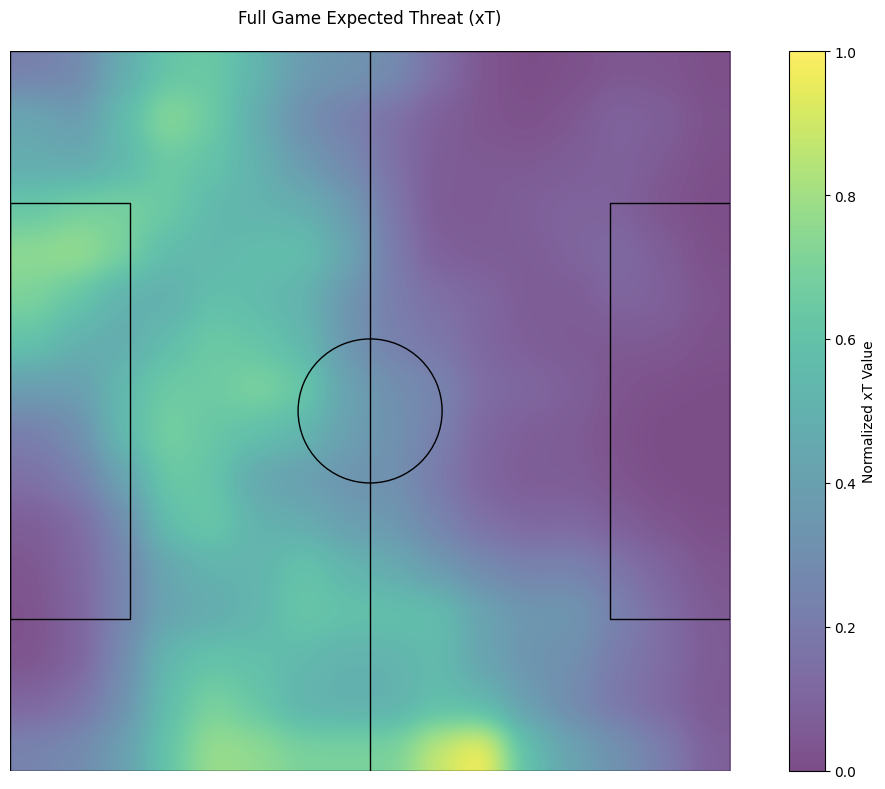

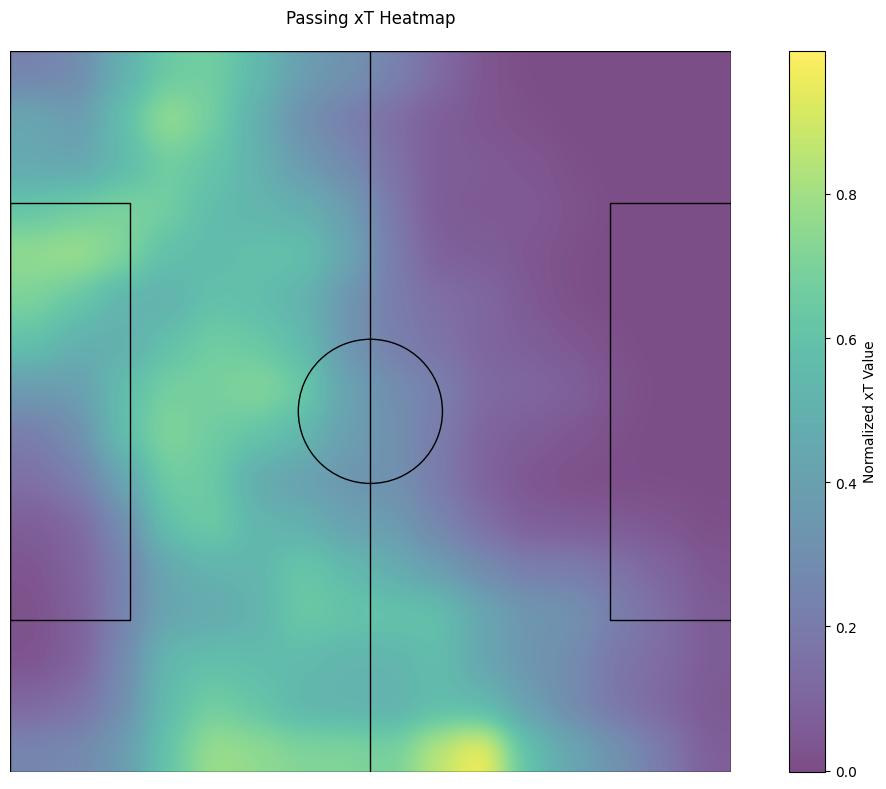

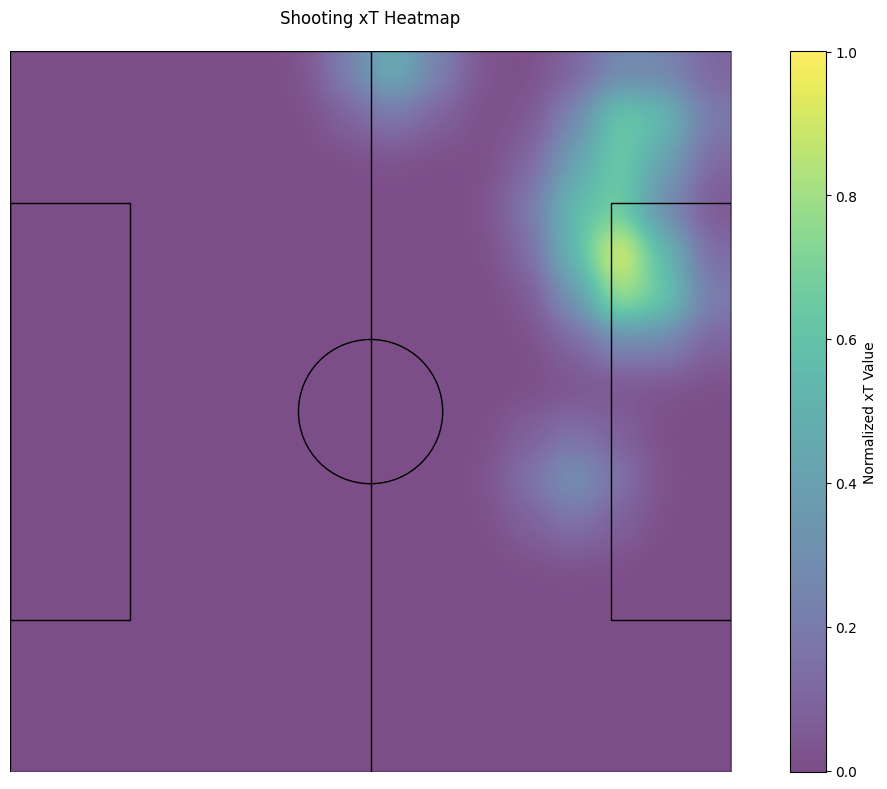

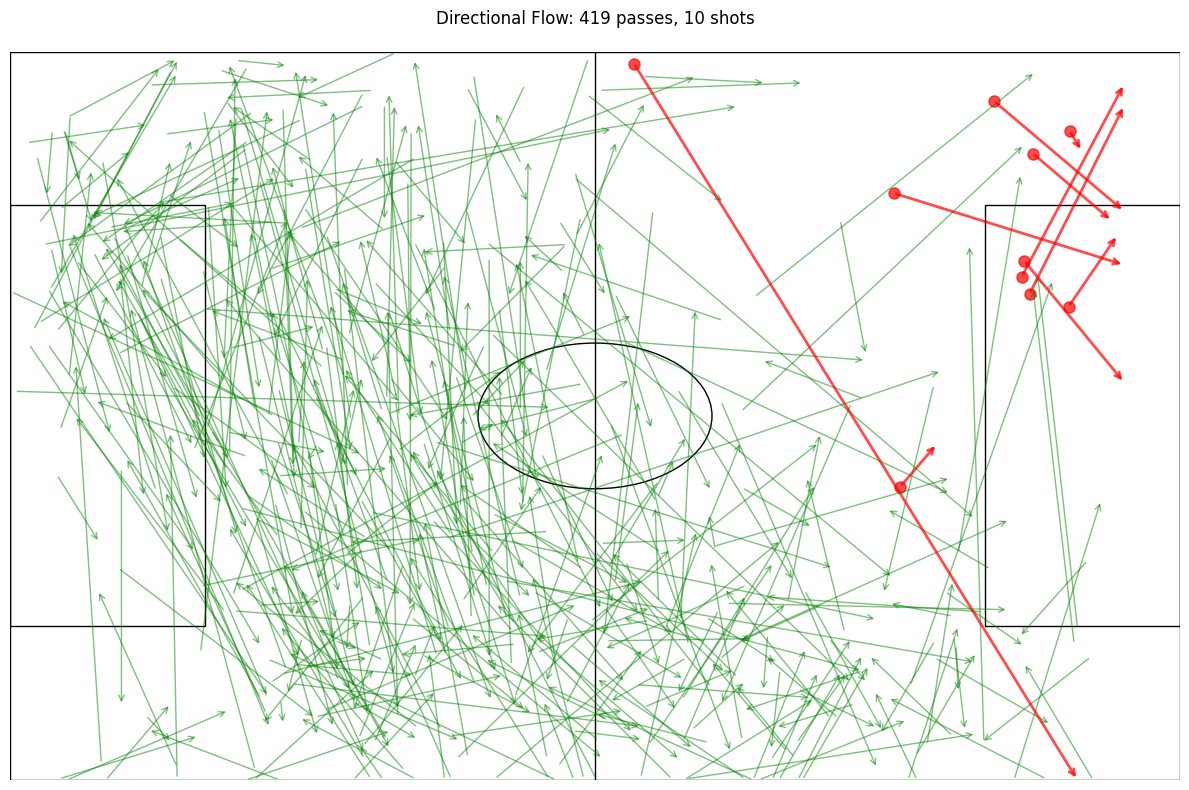

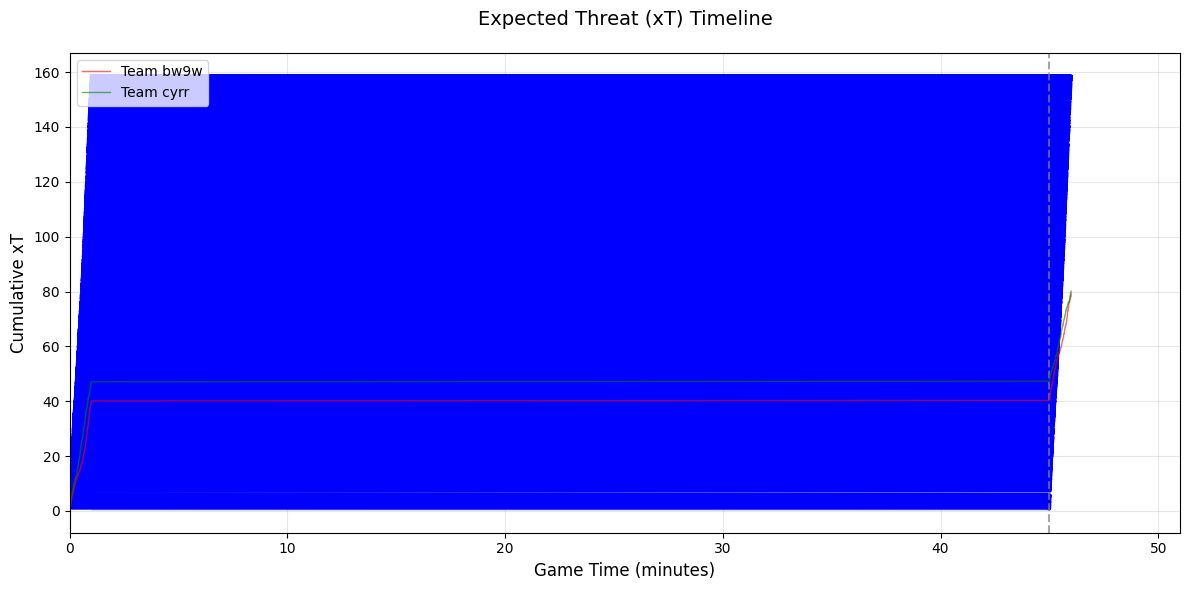

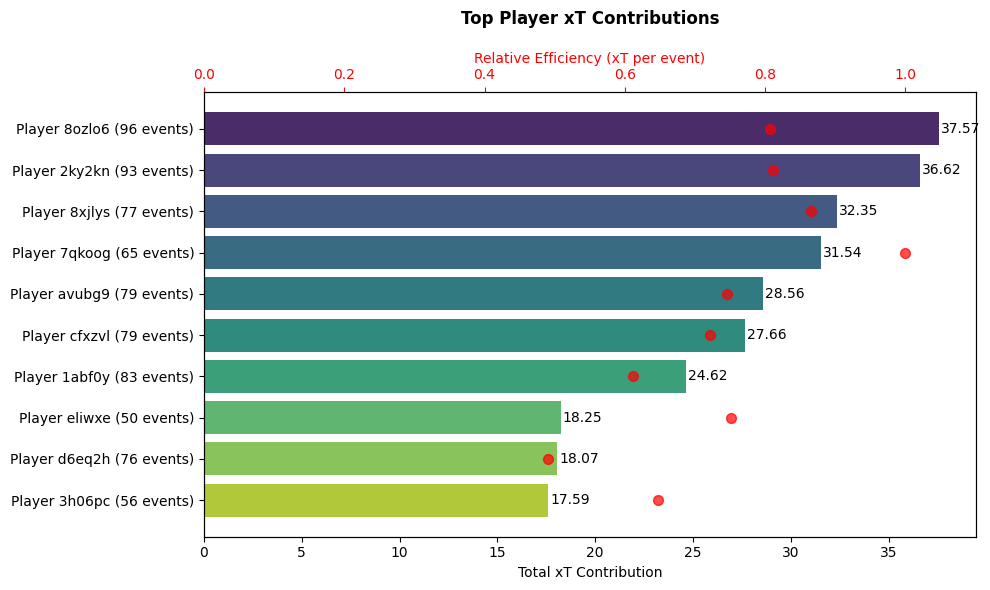

In [8]:
# Define game ID for analysis
game_id = "5oc8drrbruovbuiriyhdyiyok"

# Fetch event data
event_data = get_event_data(game_id)

if event_data.empty:
    print(f"No event data found for game_id: {game_id}")
else:
    print(f"Successfully loaded {len(event_data)} events for analysis")
    
    # Display sample data
    display(event_data.head())
    
    # Check if our mappings worked
    print("\nMapped Event Types:")
    for action_type, count in event_data['action_type'].value_counts().items():
        event_name = event_type_mapping.get(action_type, 'unknown')
        print(f"ID: {action_type}, Name: {event_name}, Count: {count}")
    
    # Check if we have passes (action_type 0) and shots (action_type 11)
    pass_count = len(event_data[event_data['action_type'] == 0])
    shot_count = len(event_data[event_data['action_type'] == 11])
    print(f"\nFound {pass_count} passes and {shot_count} shots")
    
    # Check if we have successful passes
    successful_pass_count = len(event_data[(event_data['action_type'] == 0) & 
                                          (event_data['outcome'] == 1)])
    print(f"Found {successful_pass_count} successful passes")
    
    # Calculate xT grids
    print("\nCalculating xT values...")
    xt_grids = calculate_xt(event_data)
    print("xT calculation complete!")
    
    # Create plots
    fig1, ax1 = plot_xt_heatmap(xt_grids['total'], "Full Game Expected Threat (xT)")
    fig2, ax2 = plot_xt_heatmap(xt_grids['pass'], "Passing xT Heatmap")
    fig3, ax3 = plot_xt_heatmap(xt_grids['shot'], "Shooting xT Heatmap")
    
    # Check if end coordinates columns are available
    if 'end_coordinates_x' in event_data.columns and 'end_coordinates_y' in event_data.columns:
        fig4, ax4 = plot_directional_xt(event_data)
    else:
        print("Missing end coordinates for directional analysis")
    
    # Timeline and player contributions
    fig5, ax5 = plot_xt_timeline(event_data, xt_grids)
    fig6, ax6 = plot_player_xt_contributions(event_data, xt_grids['total'])
    
    print("Analysis complete!")